# Question 1

In [1]:
# Question 1

# Question 2

## Import the relevant Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from bs4 import BeautifulSoup
import ast
from urllib.request import Request, urlopen
from itertools import combinations 

## Get header from .name file and add to dataset

In [3]:
dataset = pd.read_csv('house-votes-84.data',header=None)
soup_link2 = BeautifulSoup(open('house-votes-84.names'))
table_header = soup_link2.find('p')

def before(value, a):
    pos_a = value.find(a)
    if pos_a == -1: return ""
    return value[0:pos_a]

def after(value, a):
    pos_a = value.rfind(a)
    if pos_a == -1: return ""
    adjusted_pos_a = pos_a + len(a)
    if adjusted_pos_a >= len(value): return ""
    return value[adjusted_pos_a:]

header = after(table_header.text,"7. Attribute Information:\n")
header = before(header,"\n8. Missing Attribute Values: Denoted by")
list_header = []
for i in range(header.count('\n')):
    if(i<10):
        buffer = after(header," "+str(i+1)+". ")
    else:
        buffer = after(header,str(i+1)+". ")
    buffer = before(buffer,":")
    list_header.append(str(buffer))

dataset.columns = list_header
dataset.head()

,Class Name,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


In [4]:
dataset.shape

(435, 17)

##### There are 434 rows and 17 columns 

In [5]:
dataset.describe(include = 'object')

,Class Name,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
count,435,435,435,435,435,435,435,435,435,435,435,435,435,435,435,435,435
unique,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
top,democrat,n,y,y,n,y,y,y,y,y,y,n,n,y,y,n,y
freq,267,236,195,253,247,212,272,239,242,207,216,264,233,209,248,233,269


#### From the table above, we can see the basic data structure of dataset: 
#### All columns is categorical data
#### First column "republican" have 2 unique value which is (republican and democrat)
#### 16 other columns have 3 unique value which are y, n and ? (while ? is the missing value)

## Checking for missing values

#### Missing values is fill with "?" in the dataset so we have to take care of it


In [6]:
## replace "?" value to most frequent values in each columns
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = "?" , strategy = 'most_frequent',verbose=0)
imputer = imputer.fit(dataset.iloc[:,1:])
dataset.iloc[:, 1:] = imputer.transform(dataset.iloc[:, 1:])
display(dataset.head())

,Class Name,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,n,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,y
2,democrat,n,y,y,n,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,y,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,n,y,y,y,y


#### So that all the missing value is fill with the most frequent values
#### Because there only 2 unique values for all columns so we don't need dummy variable

## Calculate Correlation Matrix of dataset to check correlations among columns 

#### Because all columns of the dataset have categorical values so that we’re can not simply use corr() function of Pandas dataframe. we're looking for other measure of association between two categorical features.
#### By using Cramér’s V correlation which based on a nominal variation of Pearson’s Chi-Square Test will help us to handle this scenario

In [7]:
def cramers_v(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

cols = list(dataset.columns)
corrM = np.zeros((len(cols),len(cols)))
for col1, col2 in combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_v(pd.crosstab(dataset[col1], dataset[col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)

## Visualize Correlation Matrix of dataset by heat map

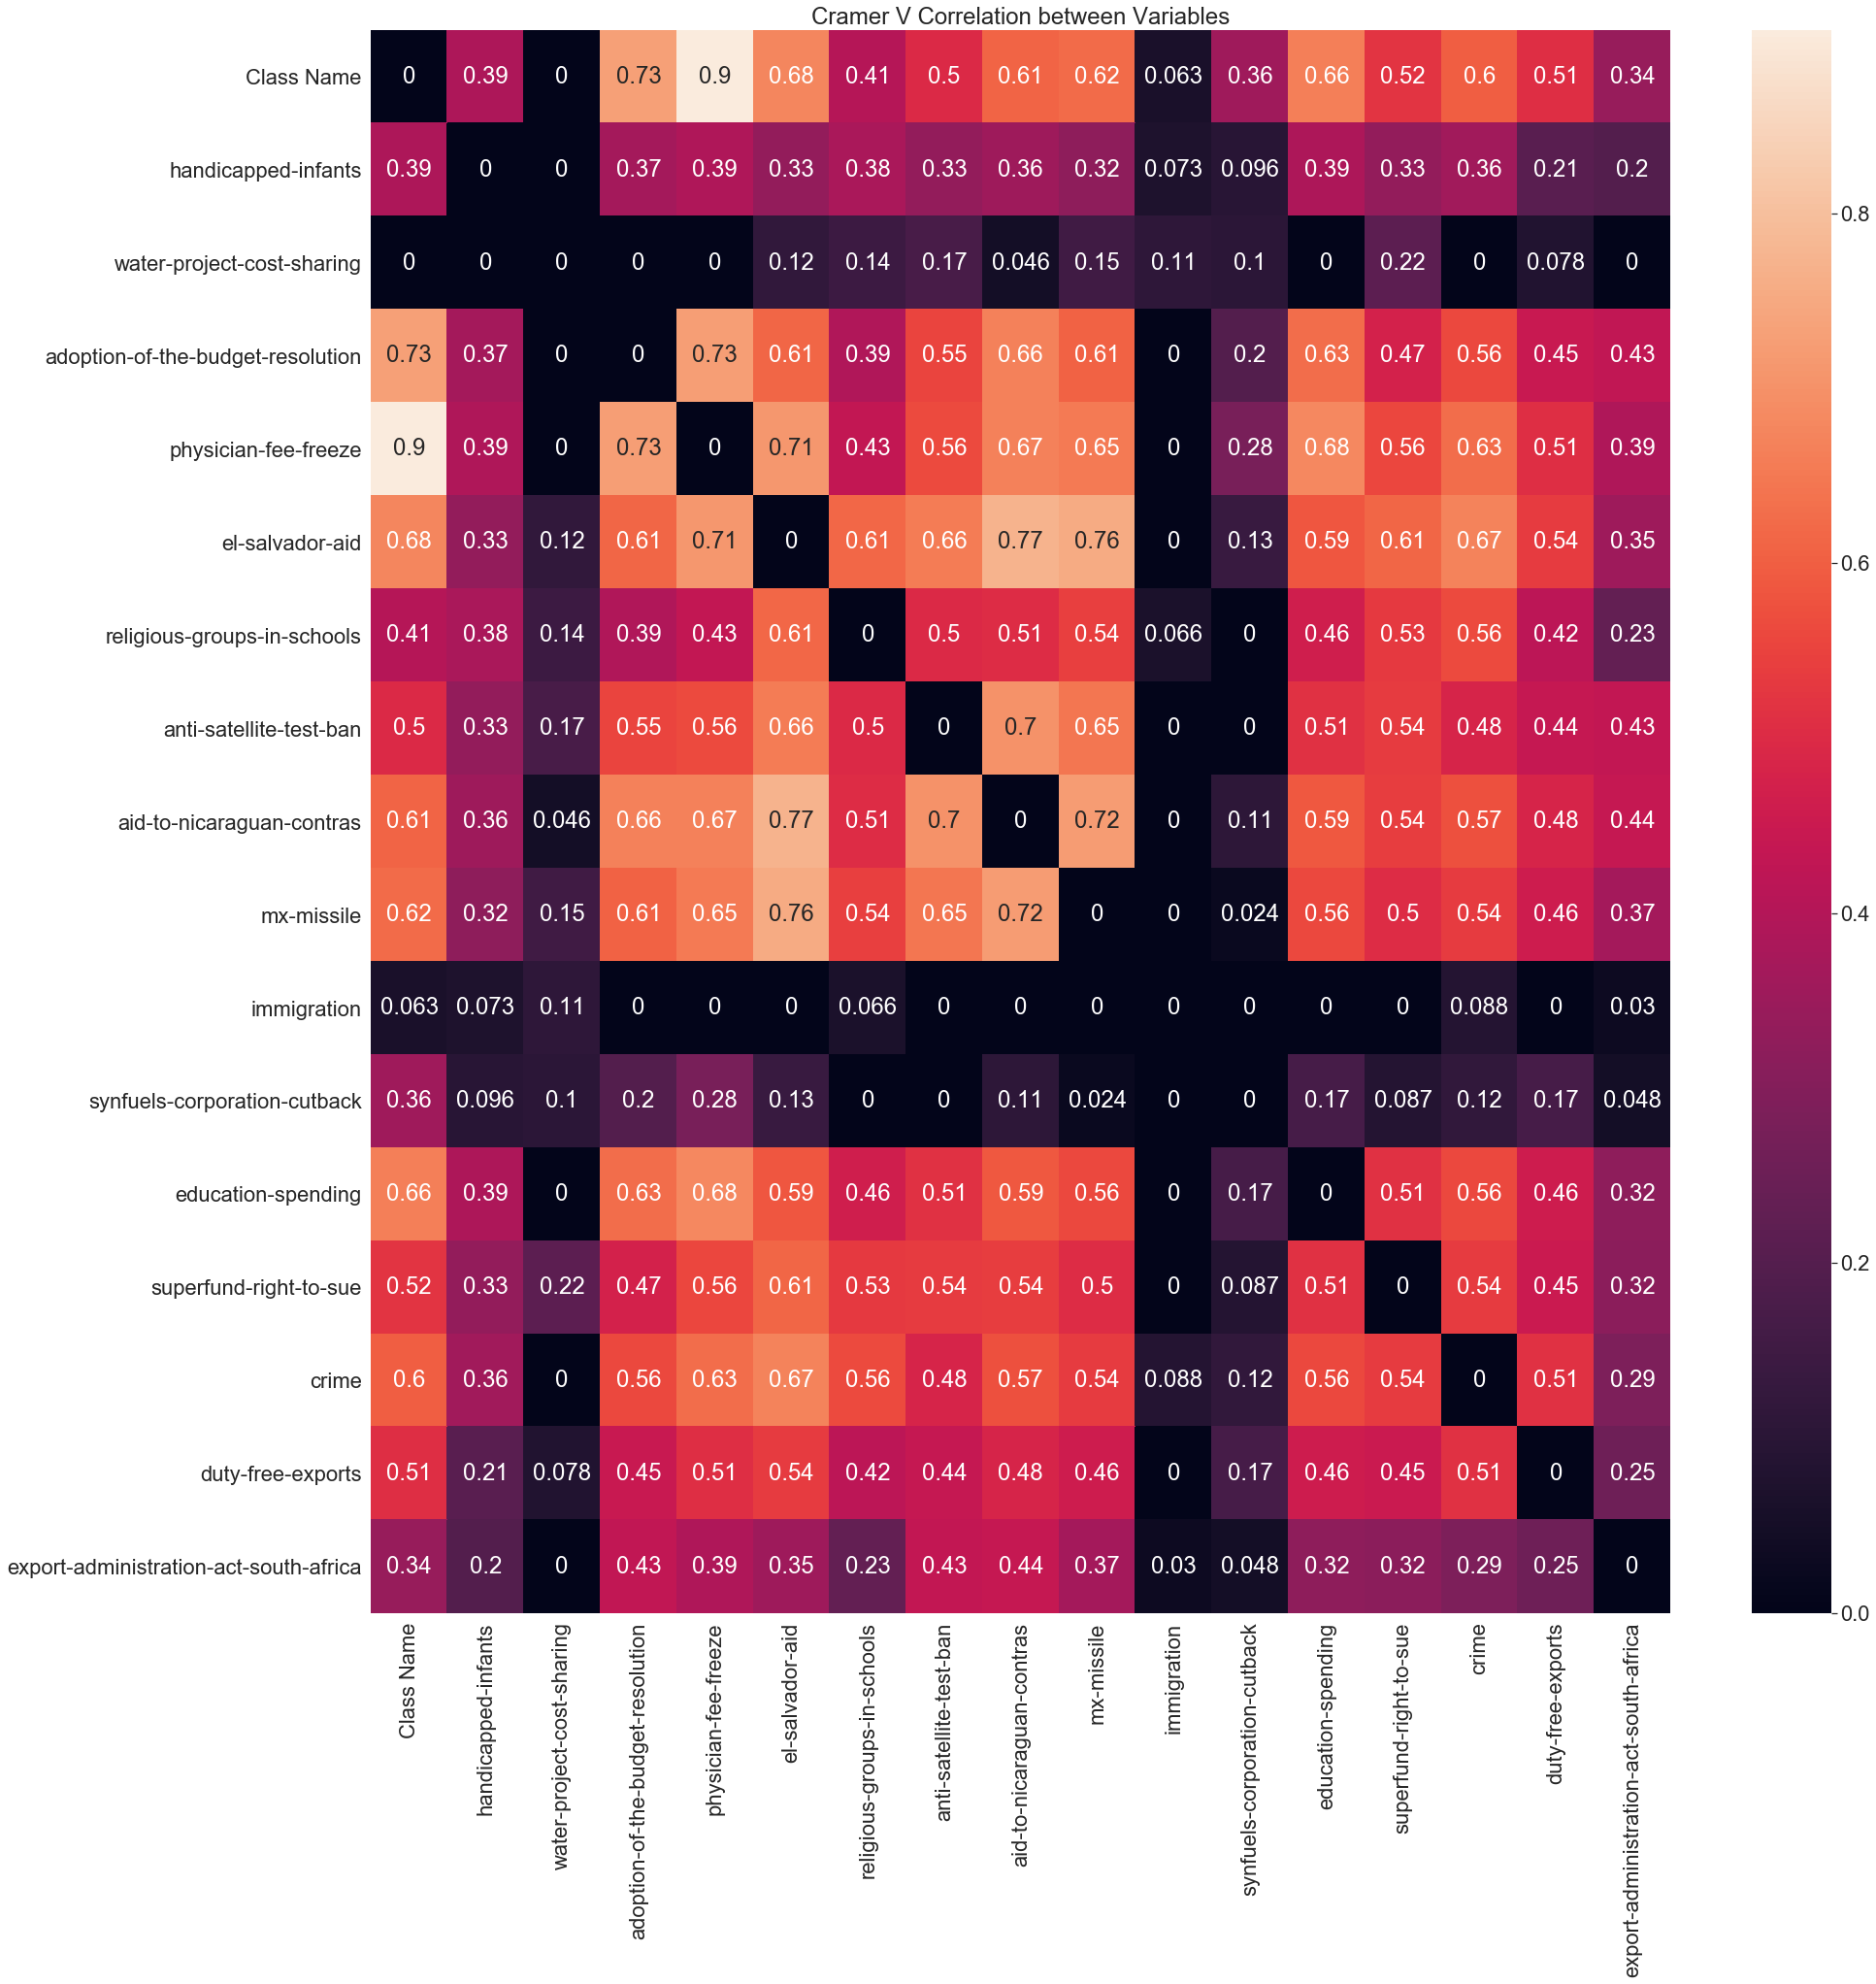

In [8]:
sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(30, 30))
ax = sns.heatmap(corr, annot=True, ax=ax); ax.set_title("Cramer V Correlation between Variables");

## Selecting features based on correlation

#### We compare the correlation between features and remove one of two features that have a correlation higher than 0.9

In [9]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
                selected_columns = dataset.columns[columns]
                new_dataset = dataset[selected_columns]
remove_columns = (list(set(dataset.columns) - set(new_dataset.columns)))
print(str(len(remove_columns))+" column removed which is: "+str(remove_columns))

1 column removed which is: ['physician-fee-freeze']


#### Now dataset has only those columns with correlation less than 0.9

In [10]:
display(new_dataset.head())

,Class Name,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,republican,n,y,n,y,y,n,n,n,y,n,y,y,y,n,y
1,republican,n,y,n,y,y,n,n,n,n,n,y,y,y,n,y
2,democrat,n,y,y,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,y,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,y,y,n,n,n,n,y,n,y,y,y,y


## Calculate distribution of selected features

#### We create new distribution dataframe for calculating

In [11]:
buffer = pd.crosstab(index = new_dataset["Class Name"],columns=new_dataset["handicapped-infants"])
buffer = buffer.stack()
buffer.index = ['_'.join(idx) for idx in buffer.index]
buffer.name = "handicapped-infants"
distribution = pd.DataFrame(buffer)
for col in new_dataset.columns:
    if (col == "Class Name") or (col == "handicapped-infants"):
        pass
    else:
        buffer = pd.crosstab(index = new_dataset["Class Name"],columns=new_dataset[col])
        buffer = buffer.stack()
        buffer.index = ['_'.join(idx) for idx in buffer.index]
        distribution[col] = buffer.values 
display(distribution)

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
democrat_n,111,119,29,200,135,59,45,60,139,138,231,179,167,107,12
democrat_y,156,148,238,67,132,208,222,207,128,129,36,88,100,160,255
republican_n,137,73,142,8,17,123,133,146,73,147,33,22,3,154,50
republican_y,31,95,26,160,151,45,35,22,95,21,135,146,165,14,118


## Plotting the data to visualize their distribution

#### Using stacked bar to plot distribution

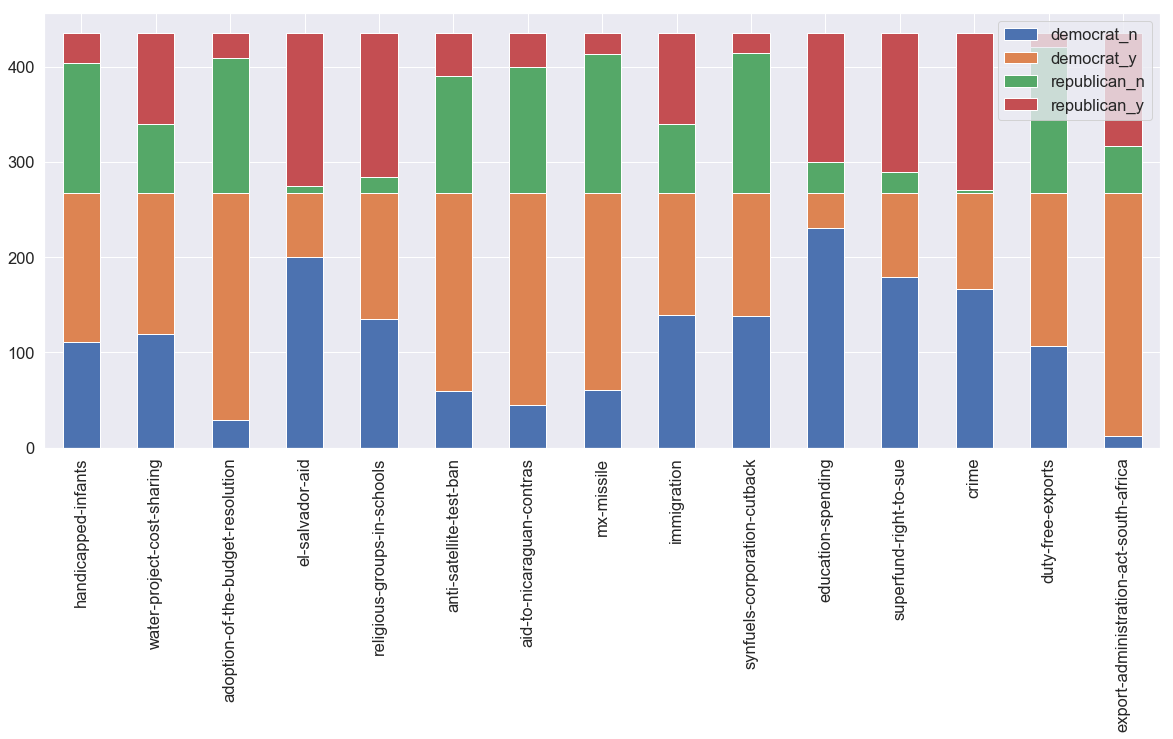

In [12]:
sns.set(font_scale=1.5)
distribution.T.plot(kind='bar', stacked=True,figsize=(20,8),label='big')

# Question 3

#### Import libraries

In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder
# Import here

#### Encode the dataset

In [60]:
lb = LabelBinarizer()
oe = OneHotEncoder(sparse=False, dtype=int)
training_dataset = dataset.copy()
dataset_features = training_dataset.drop(columns='Class Name')
dataset_classname = training_dataset['Class Name']
X = oe.fit_transform(dataset_features)
Y = lb.fit_transform(dataset_classname)

0      republican
1      republican
2        democrat
3        democrat
4        democrat
          ...    
430    republican
431      democrat
432    republican
433    republican
434    republican
Name: Class Name, Length: 435, dtype: object

## Decision Tree C4.5

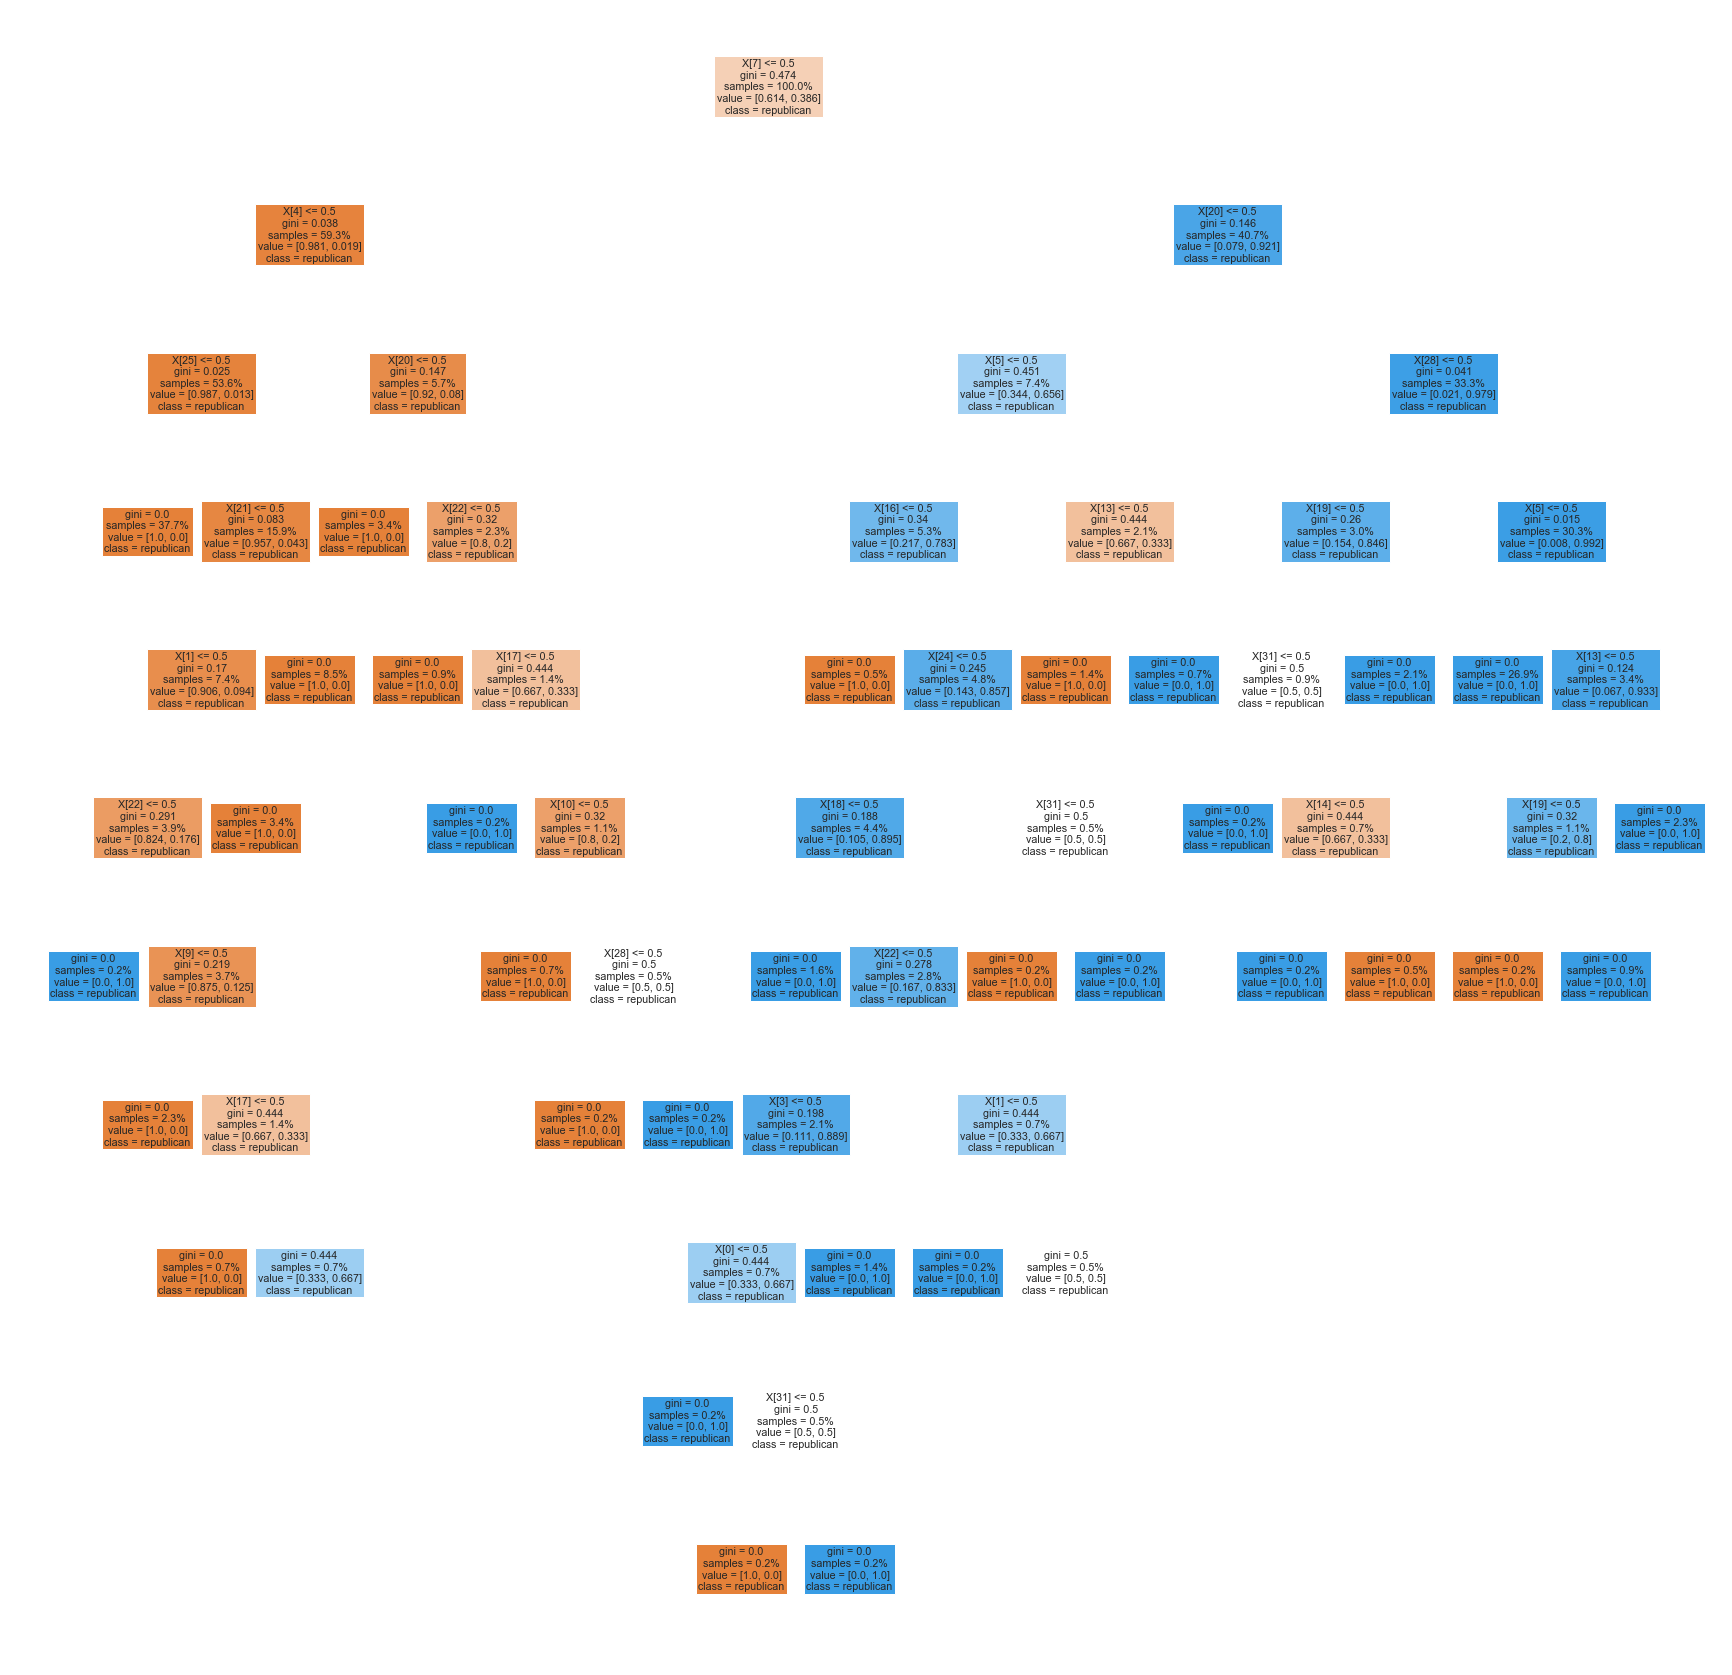

In [66]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

dtModel = DecisionTreeClassifier()
dtModel.fit(X, dataset_classname)
fig, ax = plt.subplots(figsize=(30, 30))
# plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
plot_tree(dtModel, ax=ax, class_names=dataset_classname, proportion=True, filled=True)
plt.show()

## Naive Bayes

#### Create classifier

In [327]:
# Naive Bayes classifier can be found in sklearn.naive_bayes
from sklearn.naive_bayes import GaussianNB

nbModel = GaussianNB()

## ZeroR

In ZeroR, the algorithm finds most frequent class name and return that prediction constantly   
Because the dataset has 267 'democrat' records and 168 'republican' records  
The accuracy of this ZeroR model should be **Acc = (267)/(267+168) ≈ 0.6138**

In [328]:
# ZeroR classifier (DummyClassifier) can be found in sklearn.dummy packages
from sklearn.dummy import DummyClassifier
zeroRModel = DummyClassifier(strategy='most_frequent')

zeroRModel.fit(X, dataset_classname)
print("ZeroR accuracy:", zeroRModel.score(X, dataset_classname))

ZeroR accuracy: 0.6137931034482759


# Question 4

#### Precision and Recall

In [293]:
import numpy as np
from sklearn import svm
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import precision_score, recall_score

def calc_precision_recall_f1(model, x, y, K=10):
    skf = KFold(n_splits=K, shuffle=True)
    precision_scores = []
    recall_scores = []
    f1_scores = []
    for train_index, test_index in skf.split(x, y):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = 2 * (precision * recall) / (precision + recall)
        
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
    
    return precision_scores, recall_scores, f1_scores

In [294]:
_,_,f1 = calc_precision_recall_f1(nbModel, X, Y)    #Precicion and Recall for Naive Bayes Classfier
np.mean(f1)

0.9127209966490153

# END